# DAT210x - Programming with Python for DS

## Module5- Lab3

In [30]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.cluster import KMeans

matplotlib.style.use('ggplot') # Look Pretty

A convenience function for you to use:

In [31]:
def clusterInfo(model):
    print("Cluster Analysis Inertia: ", model.inertia_)
    print('------------------------------------------')
    
    for i in range(len(model.cluster_centers_)):
        print("\n  Cluster ", i)
        print("    Centroid ", model.cluster_centers_[i])
        print("    #Samples ", (model.labels_==i).sum()) # NumPy Power

In [32]:
# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
    # Ensure there's at least on cluster...
    minSamples = len(model.labels_)
    minCluster = 0
    
    for i in range(len(model.cluster_centers_)):
        if minSamples > (model.labels_==i).sum():
            minCluster = i
            minSamples = (model.labels_==i).sum()

    print("\n  Cluster With Fewest Samples: ", minCluster)
    return (model.labels_==minCluster)

### CDRs

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) (CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records for 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!

Start by loading up the dataset and taking a peek at its `head` and `dtypes`. You can convert date-strings to real date-time objects using `pd.to_datetime`, and the times using `pd.to_timedelta`:

In [33]:
df = pd.read_csv('Datasets/CDR.csv')
df.head()

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389


In [34]:
df.CallDate = pd.to_datetime(df.CallDate)
df.CallTime = pd.to_timedelta(df.CallTime)
df.Duration = pd.to_timedelta(df.Duration)
df.dtypes

In                     int64
Out                    int64
Direction             object
CallDate      datetime64[ns]
CallTime     timedelta64[ns]
DOW                   object
Duration     timedelta64[ns]
TowerID               object
TowerLat             float64
TowerLon             float64
dtype: object

Create a unique list of the phone number values (people) stored in the `In` column of the dataset, and save them in a regular python list called `unique_numbers`. Manually check through `unique_numbers` to ensure the order the numbers appear is the same order they (uniquely) appear in your dataset:

In [35]:
in_list = np.array(df.In)
in_list.tolist()
indexes = np.unique(in_list, return_index = True)[1]
unique_numbers = [in_list[index] for index in sorted(indexes)]
unique_numbers

[4638472273,
 1559410755,
 4931532174,
 2419930464,
 1884182865,
 3688089071,
 4555003213,
 2068627935,
 2894365987,
 8549533077]

Using some domain expertise, your intuition should direct you to know that people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

In [37]:
print("Examining person: ", 0)

('Examining person: ', 0)


Create a slice called `user1` that filters to only include dataset records where the `In` feature (user phone number) is equal to the first number on your unique list above:

In [38]:
user1 = df.loc[df.In == unique_numbers[0]]

Alter your slice so that it includes only Weekday (Mon-Fri) values:

In [39]:
user1 = user1.loc[(user1.DOW != 'Sat') & (user1.DOW != 'Sun')]

The idea is that the call was placed before 5pm. From Midnight-730a, the user is probably sleeping and won't call / wake up to take a call. There should be a brief time in the morning during their commute to work, then they'll spend the entire day at work. So the assumption is that most of the time is spent either at work, or in 2nd, at home:

In [40]:
#user1 = user1.loc[(user1.CallTime < "17:00:00") | (user1.CallTime > "07:30:00")]
user1 = user1.loc[(user1.CallTime < "17:00:00")]

Plot the Cell Towers the user connected to

In [48]:
def doKMeans(data, num_clusters=0):
    # TODO: Be sure to only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
    # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
    # no feature scaling is required. Print out the centroid locations and add them onto your scatter
    # plot. Use a distinguishable marker and color.
    #
    # Hint: Make sure you fit ONLY the coordinates, and in the CORRECT order (lat first). This is part
    # of your domain expertise. Also, *YOU* need to create, initialize (and return) the variable named
    # `model` here, which will be a SKLearn K-Means model for this to work:
    
    # TODO: Filter `df` using indexing so it only contains Longitude and Latitude,
    # since the remaining columns aren't really applicable for this lab:
    #
    
    data = data.loc[:,['TowerLon','TowerLat']]

    # TODO: Use K-Means to try and find seven cluster centers in this df.
    # Be sure to name your kmeans model `model` so that the printing works.
    #
    model = KMeans(n_clusters=num_clusters)
    model.fit(data)
    labels = model.predict(data)
    
    return model

Let's tun K-Means with `K=3` or `K=4`. There really should only be a two areas of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another), then increase K=5, with the goal being that all centroids except two will sweep up the annoying outliers and not-home, not-work travel occasions. the other two will zero in on the user's approximate home location and work locations. Or rather the location of the cell tower closest to them.....

In [78]:
model = doKMeans(user1, 4)

Print out the mean `CallTime` value for the samples belonging to the cluster with the LEAST samples attached to it. If our logic is correct, the cluster with the MOST samples will be work. The cluster with the 2nd most samples will be home. And the `K=3` cluster with the least samples should be somewhere in between the two. What time, on average, is the user in between home and work, between the midnight and 5pm?

In [79]:
midWayClusterIndices = clusterWithFewestSamples(model)
midWaySamples = user1[midWayClusterIndices]
print("    Its Waypoint Time: ", midWaySamples.CallTime.mean())

('\n  Cluster With Fewest Samples: ', 3)
('    Its Waypoint Time: ', Timedelta('0 days 07:47:50.059087'))


Let's visualize the results! First draw the X's for the clusters:

<IPython.core.display.Javascript object>


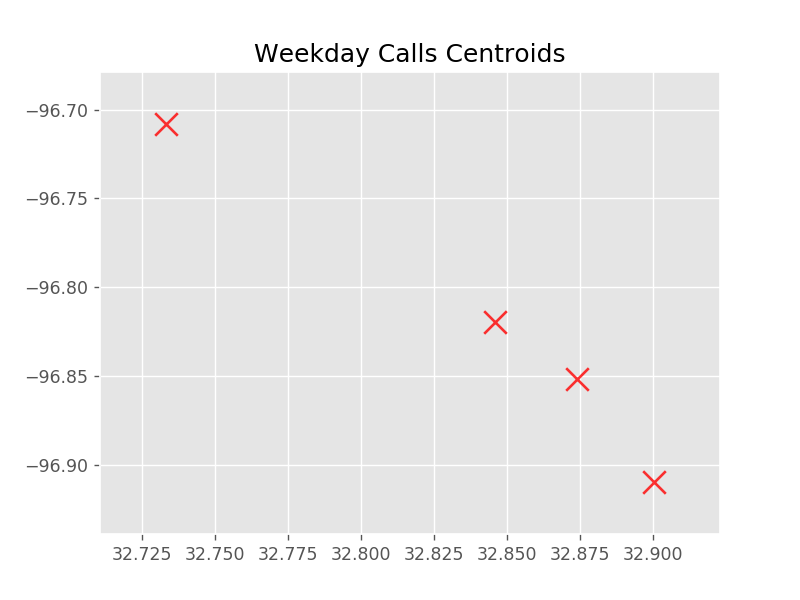

[[-96.90967196  32.9001744 ]
 [-96.70816184  32.73323174]
 [-96.85151976  32.87385429]
 [-96.81945506  32.84577996]]


In [80]:
fig = plt.figure()
ax = fig.add_subplot(111)

print(model.cluster_centers_)

ax.scatter(model.cluster_centers_[:,1], model.cluster_centers_[:,0], s=169, c='r', marker='x', alpha=0.8, linewidths=2)
ax.set_title('Weekday Calls Centroids')
plt.show()

In [81]:
clusterInfo(model)

('Cluster Analysis Inertia: ', 0.10279744651524612)
------------------------------------------
('\n  Cluster ', 0)
('    Centroid ', array([-96.90967196,  32.9001744 ]))
('    #Samples ', 953)
('\n  Cluster ', 1)
('    Centroid ', array([-96.70816184,  32.73323174]))
('    #Samples ', 306)
('\n  Cluster ', 2)
('    Centroid ', array([-96.85151976,  32.87385429]))
('    #Samples ', 94)
('\n  Cluster ', 3)
('    Centroid ', array([-96.81945506,  32.84577996]))
('    #Samples ', 52)


In [75]:
new_list = [4638472273,2068627935,1559410755,2894365987,3688089071]
%matplotlib notebook
for u in new_list:
    user = df.loc[df.In == u]
    #weekend
    user = user.loc[(user.DOW != 'Sat') & (user.DOW != 'Sun')]
    #post midnight
    user = user.loc[(user.CallTime < "17:00:00")]
    #Kmeans
    model = doKMeans(user, 4)
    clusterInfo(model)

('Cluster Analysis Inertia: ', 0.10279744651524612)
------------------------------------------
('\n  Cluster ', 0)
('    Centroid ', array([-96.90967196,  32.9001744 ]))
('    #Samples ', 953)
('\n  Cluster ', 1)
('    Centroid ', array([-96.70816184,  32.73323174]))
('    #Samples ', 306)
('\n  Cluster ', 2)
('    Centroid ', array([-96.85151976,  32.87385429]))
('    #Samples ', 94)
('\n  Cluster ', 3)
('    Centroid ', array([-96.81945506,  32.84577996]))
('    #Samples ', 52)
('Cluster Analysis Inertia: ', 0.15270229698945337)
------------------------------------------
('\n  Cluster ', 0)
('    Centroid ', array([-96.83278954,  32.72089181]))
('    #Samples ', 1497)
('\n  Cluster ', 1)
('    Centroid ', array([-96.604444,  32.703056]))
('    #Samples ', 392)
('\n  Cluster ', 2)
('    Centroid ', array([-96.75520357,  32.71410598]))
('    #Samples ', 254)
('\n  Cluster ', 3)
('    Centroid ', array([-96.8066212 ,  32.72178311]))
('    #Samples ', 151)
('Cluster Analysis Inertia: ', 